In [1]:
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
import keras 
import random


from matplotlib import pyplot as plt
from keras.utils import normalize
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from albumentations import RandomResizedCrop, RandomRotate90, GridDistortion, PixelDropout
from albumentations import MedianBlur, RandomSnow, CropNonEmptyMaskIfExists
from tqdm import tqdm

drive.mount('/content/drive')

path_dir="/content/drive/MyDrive/Colab Notebooks/Progetto_Deep/car-segmentation"
os.chdir(path_dir)

Mounted at /content/drive


In [2]:
def load_data(path):
    files = sorted(glob.glob(os.path.join(path, "images/*")))
    files2 = sorted(glob.glob(os.path.join(path, "masks/*")))

    zipped = list(zip(files, files2))  

    # Randomizzo i file delle cartelle images e mask    
    random.shuffle(zipped)                              
    list1, list2 = zip(*zipped)

    # Converto le tuple nuovamente in liste
    images, masks = list(list1), list(list2)       

    return images, masks

In [3]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def augment_data(images, masks, save_path):
      
    # Dizionario per alcune immagini da escludere nelle funzioni di Crop perché
    # altrimenti darebbero problemi in quanto hanno dimensioni
    # inferiori a 128x128 o 256x256
    accepted_strings = {'image%20(10)', 'image_20(10)', 'image%20(14)', 'image_20(14)', 
                        '156551_preview', 'd9ce7968a4073918ce554523363caa73', 
                        'image%20(12)', 'image_20(12)', 'image_20(11)', 'image%20(11)',
                        'image_20(15)','image%20(15)','image_20(16)', 'image%20(16)',
                        'image_20(13)','image%20(13)'}  
    for x, y in tqdm(zip(X1, Y1), total=len(X1)):

        # Estraggo il nome del file in image e mask
        name = x.split("/")[-1].split(".")
        image_name = name[0]
               
        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        aug = RandomRotate90(always_apply=True, p=1.0)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']

        aug = MedianBlur(always_apply=False, p=1.0, blur_limit=(9, 13))
        augmented = aug(image=x, mask=y)
        x3 = augmented['image']
        y3 = augmented['mask']

        aug = RandomSnow(always_apply=False, p=1.0, snow_point_lower=0.1, snow_point_upper=0.2, brightness_coeff=2.5)
        augmented = aug(image=x, mask=y)
        x4 = augmented['image']
        y4 = augmented['mask']

        
        aug = PixelDropout(always_apply=False, p=1.0, dropout_prob=0.42, per_channel=0, drop_value=(0, 0, 0), mask_drop_value=None)
        augmented = aug(image=x, mask=y)
        x6 = augmented['image']
        y6 = augmented['mask']

        if image_name in accepted_strings:
          img_aug = [x, x2, x3, x4, x6]
          mask_aug = [y, y2, y3, y4, y6]

          num = 0
          for xx, yy in zip(img_aug, mask_aug):

            # Ridimensione ogni immagine e maschera di cui ho fatto Data Seg 
            i = cv2.resize(xx, (SIZE_X, SIZE_Y))
            m = cv2.resize(yy, (SIZE_X, SIZE_Y))
          
            # Ogni nuova immagine e maschera generata con dataset aug avrà
            # lo stesso nome dell'immagine originale più un intero incrementale
            image_path = os.path.join(save_path, "images", f"{image_name}_{num}.png")
            mask_path = os.path.join(save_path, "masks", f"{mask_name}_{num}.png")

            # Salvo l'immagine e la maschera ridimensionata nelle nuove rispettive 
            # cartelle "images" e "masks"
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            num = num + 1

        else:

          # Eseguo la segmentazione delle immagini e maschere
          aug = RandomResizedCrop(SIZE_X, SIZE_Y, p=1, scale=(0.48, 1.0))
          augmented = aug(image=x, mask=y)
          x1 = augmented["image"]
          y1 = augmented["mask"]

          aug = CropNonEmptyMaskIfExists(SIZE_X, SIZE_Y, ignore_values=[1,2], always_apply=False, p=1.0)
          augmented = aug(image=x, mask=y)
          x5 = augmented['image']
          y5 = augmented['mask']

          img_aug = [x, x1, x2, x3, x4, x5, x6]
          mask_aug = [y, y1, y2, y3, y4, y5, y6]

          num = 0
          for xx, yy in zip(img_aug, mask_aug):

            # Ridimensione ogni immagine e maschera di cui ho fatto Data Seg 
            i = cv2.resize(xx, (SIZE_X, SIZE_Y))
            m = cv2.resize(yy, (SIZE_X, SIZE_Y))
          
            # Ogni nuova immagine e maschera generata con dataset aug avrà
            # lo stesso nome dell'immagine originale più un intero incrementale
            image_path = os.path.join(save_path, "images", f"{image_name}_{num}.png")
            mask_path = os.path.join(save_path, "masks", f"{mask_name}_{num}.png")

            # Salvo l'immagine e la maschera ridimensionata nelle nuove rispettive 
            # cartelle "images" e "masks"
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            num = num + 1

In [4]:
def stampa_senza_back(test_img, mask_truth, mask_pred2, mask_pred3):

  fig, axs = plt.subplots(1, 4, figsize=(12, 4))
  
  axs[0].set_title('Immagine originale')
  axs[0].imshow(test_img, cmap='jet')
  
  axs[1].set_title('Maschera originale')
  axs[1].imshow(mask_truth, cmap='jet')
  
  axs[2].set_title('Predizione del modello Unet')
  axs[2].imshow(mask_pred2, cmap='jet')
  
  axs[3].set_title('Predizione del modello Mobile')
  axs[3].imshow(mask_pred3, cmap='jet')
  
  plt.tight_layout()
  plt.show()



def stampa_con_back(test_img, mask_truth, mask_pred2, mask_pred3):
  
  # Tolgo la classe 0(background) dalle maschere
  masked_true = np.ma.masked_where(mask_truth == 0, mask_truth)
  masked_pred = np.ma.masked_where(mask_pred2 == 0, mask_pred2)
  masked_pred_Mobile = np.ma.masked_where(mask_pred3 == 0, mask_pred3)


  fig, axs = plt.subplots(1, 4, figsize=(12, 4))
  
  axs[0].set_title('Immagine originale')
  axs[0].imshow(test_img, cmap='jet')
  
  axs[1].set_title('Maschera originale')
  axs[1].imshow(test_img, cmap='jet')
  axs[1].imshow(masked_true, cmap='jet', interpolation='none', alpha=0.6)
  
  axs[2].set_title('Predizione del modello Unet')
  axs[2].imshow(test_img, cmap='jet')
  axs[2].imshow(masked_pred, cmap='jet', interpolation='none', alpha=0.6)
  
  axs[3].set_title('Predizione del modello Mobile')
  axs[3].imshow(test_img, cmap='jet')
  axs[3].imshow(masked_pred_Mobile, cmap='jet', interpolation='none', alpha=0.6)
  
  plt.tight_layout()
  plt.show()

  

def stampa_previsone(model_n):
  # Numero random sceltra tra un intervallo
  int_r = random.randint(0, len(X_test))

  test_img = test_image[int_r]
  mask_truth = test_mask[int_r]

  # Aumentiamo la dimensione dell'array per poterlo dare in 
  # input al modello per la predizione.
  # Il nuovo array avrà dim (1, H, W, 3)
  test_img_exp = np.expand_dims(test_img, axis=0)

  mask_pred = model_n.predict(test_img_exp)

  # Ottieniamo il un nuovo array che contiene l'indice della classe predetta per ogni pixel. 
  # Mentre con [0,:,:] selezioniamo il primo elemento del batch.
  mask_pred2 = np.argmax(mask_pred, axis=3)[0,:,:]

  # Convertiamo il tipo di dato in float32 (se richiesto dal modello TFLite)
  input_image = test_img_exp.astype(np.float32)
  tflite_interpreter.set_tensor(input_details[0]['index'], input_image)

  # Eseguo il modello TFLite
  tflite_interpreter.invoke()
  output_data = tflite_interpreter.get_tensor(output_details[0]['index'])

  mask_pred3 = np.argmax(output_data, axis=3)[0,:,:]

  stampa_con_back(test_img, mask_truth, mask_pred2, mask_pred3)
  stampa_senza_back(test_img, mask_truth, mask_pred2, mask_pred3)




In [5]:
def stampa_grafico(model_n):
  loss = model_n.history.history['val_loss']
  val_iou_me1 = model_n.history.history['val_iou_me']

  plt.figure()
  plt.plot( loss, 'r', label='Validation iou loss')
  plt.plot( val_iou_me1, 'g', label='Validation iou metric')
  plt.xlabel('Epoch')
  plt.ylim([0, 1])
  plt.legend()
  plt.show()

# **IoU**

IoU (Intersection over Union) è una metrica utilizzata spesso per la segmentazione semantica che permette di valutare la sovrapposizione tra due insiemi, in questo caso tra la maschera predetta e la maschera di verità.

L'IoU viene calcolato come il rapporto tra l'area dell'intersezione e l'area dell'unione tra due regioni.
È un valore compreso tra 0 e 1, dove un valore più vicino a 1 indica una maggiore sovrapposizione tra le maschere e quindi una migliore performance del modello.

In [6]:

def iou_me(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2)) - intersection
    iou = intersection / union
    
    return iou

def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2)) - intersection
    iou = intersection / union
    loss = 1 - iou
    return loss

In [7]:
# Valori per ridimensionamento immagini
SIZE_X = 128
SIZE_Y = 128

# Controllo il numero delle classi da individuare aprendo il file "classes.txt"
file = open((path_dir+"/classes.txt"), "rt")
data = file.read()
words = data.split(',')

# Numeor di classi per la segmentazione
n_classes= len(words) 
print("Numero di classi: "+ str(n_classes))

Numero di classi: 5


In [8]:
images, masks = load_data(path_dir)

# Divido le immagini e le maschere in train e test
X1, X_test, Y1, Y_test = train_test_split(images, masks, shuffle = False, test_size = 0.3)
print("X1: " + str(len(X1)))
print("X_test: " + str(len(X_test)))
print("Y1: " + str(len(Y1)))
print("Y_test: " + str(len(Y_test)))


test_image = [] 
for x in X_test:
      image = cv2.imread(x, 1)    
      image = cv2.resize(image, (SIZE_X, SIZE_Y), interpolation = cv2.INTER_NEAREST) 
      test_image.append(image)
        
# Converto le liste in array per l'elaborazione         
test_image = np.array(test_image)
print("Size -> test_image: " + str((test_image.shape)))

test_mask = [] 
for x in Y_test:
      mask = cv2.imread(x, 0)      
      mask = cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation = cv2.INTER_NEAREST)  
      test_mask.append(mask)
        
# Converto le liste in array per l'elaborazione         
test_mask = np.array(test_mask)
print("Size -> test_mask: " + str((test_mask.shape)))

X1: 147
X_test: 64
Y1: 147
Y_test: 64
Size -> test_image: (64, 128, 128, 3)
Size -> test_mask: (64, 128, 128)


### Data Augmentation

In [9]:
# Creazione cartelle di Data Augmentation per train e masks
create_dir(path_dir+ "/train/images")
create_dir(path_dir+ "/train/masks")

augment_data(images, masks, path_dir+ "/train/") 

100%|██████████| 147/147 [03:27<00:00,  1.41s/it]


Size -> train_images: (1015, 128, 128, 3)


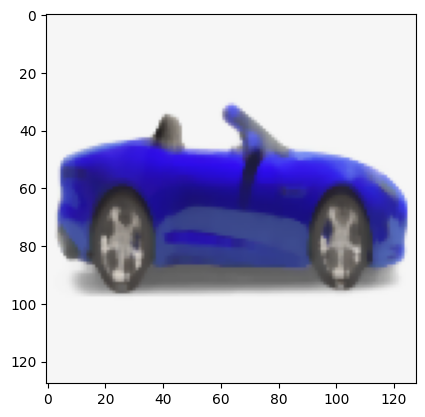

In [10]:
# Creo una lista in cui inserico le immagini di training
train_images = []

for path_dir in glob.glob("train/images/"):
    for img_path in (glob.glob(os.path.join(path_dir, "*.png"))):
        img = cv2.imread(img_path, 1)     
        train_images.append(img)
        
train_images = np.array(train_images)
print("Size -> train_images: " + str((train_images.shape)))

# Provo a stampare l'elemento # per vedere se combacia 
# con la controparte delle maschere
plt.imshow(train_images[80])

Size -> train_masks: (1015, 128, 128)


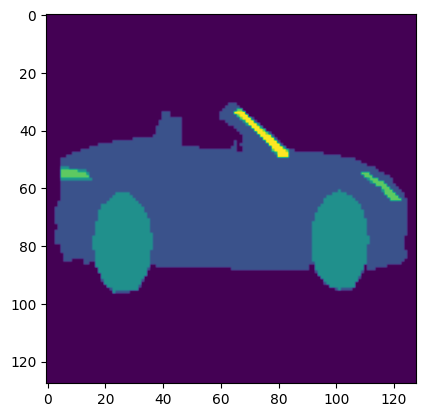

In [11]:
#Creo una lista in cui inserico le maschere di training
train_masks = [] 

for directory_path in glob.glob("train/masks/"):
    for mask_path in (glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0) 
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print("Size -> train_masks: " + str((train_masks.shape)))

# Provo a stampare l'elemento # per vedere se combacia 
# con la controparte delle immagini
plt.imshow(train_masks[80])

### One Hot Encoding

Il One-Hot Encoding è una delle tecniche di codifica più utilizzate per la classificazione multiclasse. In questo caso prendendosi prendono dei vettori di lunghezza uguale al # di categorie, rappresentando ogni categoria con 1 in una posizione particolare e 0 nelle altre posizioni.

In [12]:
train_masks_cat = to_categorical(train_masks, num_classes=n_classes)
Y_train_cat = train_masks_cat.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], n_classes))
print("Y_train_cat: " + str(Y_train_cat.shape) )


test_masks_cat = to_categorical(test_mask, num_classes=n_classes)
Y_test_cat = test_masks_cat.reshape((test_mask.shape[0], test_mask.shape[1], test_mask.shape[2], n_classes))
print("Y_test_cat: " + str(Y_test_cat.shape) )


#train_masks_n = np.unique(train_masks,return_counts=True)
#print(train_masks_n[1])

Y_train_cat: (1015, 128, 128, 5)
Y_test_cat: (64, 128, 128, 5)


### Modello U-Net

Per affrontare il problema della segmentazione semantica abbiamo deciso di utilizzare un approccio completamente convoluzionale (FCN) in particolare abbiamo utilizzato l'architettura U-Net.
La U-Net è costituita da una parte di encoder che riduce (down-sample) l’immagine in ingresso in una feature map estraendone gli elementi chiave(tramite  livelli di convoluzione e di max pooling), e una parte di decoder che amplifica (up sample) la feature map in una immagine, usando i livelli di deconvoluzione(convoluzioni trasposte).
La caratteristica distintiva di U-Net è l'utilizzo delle skip-connection che permettono di trasportare più informazioni dagli strati di encoder a quelli di decoder.

In [13]:
def convolution_operation(entered_input, filters):
    # Applico due strati convoluzionali, ognuno seguito da una normalizzazione del batch e da una funzione di attivazione ReLU
    # Prendo il primo input e implemento il primo blocco di convoluzione 
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Prendo il primo input e implemento il secondo blocco di convoluzione
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

def encoder(entered_input, filters):
    # Prendo un input e applico un blocco di convoluzione. 
    # Poi eseguo max pooling per ridurre le dimensioni dell'immagine. 
    # Restituisce l'output del blocco di convoluzione (enc1) e l'output del max pooling (MaxPool1), utilizzati come skip connection durante la fase di decodifica.
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1



def decoder(entered_input, skip, filters):
    # Prendo l'input, l'output di un'operazione di skip connection (skip) e applico una fase di upsampling tramite la convoluzione trasposta. 
    # Poi concateno l'output dell'upsampling con quello dello skip connection
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [14]:
def U_Net(Image_Size):
    
    input1 = Input(Image_Size)
    
    # Blocchi encoder 
    skip1, encoder_1 = encoder(input1, 32)
    skip2, encoder_2 = encoder(encoder_1, 32*2)
    skip3, encoder_3 = encoder(encoder_2, 32*4)
    skip4, encoder_4 = encoder(encoder_3, 32*8)
    
    
    conv_block = convolution_operation(encoder_4, 32*16)
    
    # Blocchi decoder
    decoder_1 = decoder(conv_block, skip4, 32*8)
    decoder_2 = decoder(decoder_1, skip3, 32*4)
    decoder_3 = decoder(decoder_2, skip2, 32*2)
    decoder_4 = decoder(decoder_3, skip1, 32)
    
    out = Conv2D(n_classes, 1, padding="same", activation="softmax")(decoder_4)

    model = Model(input1, out)
    return model

In [15]:
model_UN = U_Net((SIZE_X,SIZE_Y,3))

model_UN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
               loss = iou_loss, 
               metrics = iou_me)
model_UN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss')]

model_UN.fit(train_images, Y_train_cat, validation_data=(test_image,Y_test_cat), batch_size=8, epochs=30, callbacks = callbacks)

Epoch 1/30
127/127 [==============================] - 37s 79ms/step - loss: 0.7896 - iou_me: 0.2104 - val_loss: 0.8129 - val_iou_me: 0.1871
Epoch 2/30
127/127 [==============================] - 7s 53ms/step - loss: 0.6264 - iou_me: 0.3736 - val_loss: 0.5643 - val_iou_me: 0.4357
Epoch 3/30
127/127 [==============================] - 7s 55ms/step - loss: 0.5480 - iou_me: 0.4520 - val_loss: 0.4909 - val_iou_me: 0.5091
Epoch 4/30
127/127 [==============================] - 7s 54ms/step - loss: 0.5011 - iou_me: 0.4989 - val_loss: 0.4582 - val_iou_me: 0.5418
Epoch 5/30
127/127 [==============================] - 7s 56ms/step - loss: 0.4675 - iou_me: 0.5325 - val_loss: 0.4366 - val_iou_me: 0.5634
Epoch 6/30
127/127 [==============================] - 7s 56ms/step - loss: 0.4409 - iou_me: 0.5591 - val_loss: 0.4125 - val_iou_me: 0.5875
Epoch 7/30
127/127 [==============================] - 7s 56ms/step - loss: 0.4177 - iou_me: 0.5823 - val_loss: 0.3892 - val_iou_me: 0.6108
Epoch 8/30
127/127 [======

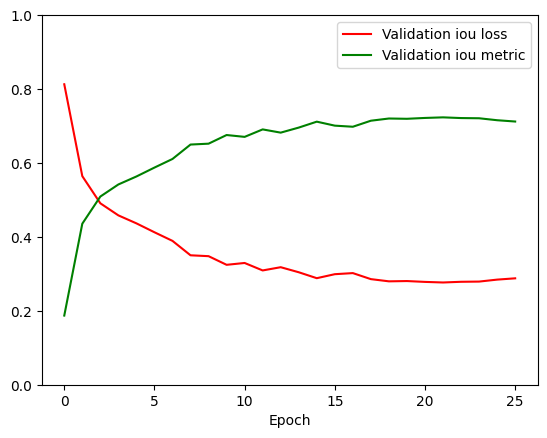

In [17]:
stampa_grafico(model_UN)


### Modello Mobile

 Per la parte mobile è stato implementata un'archiettura U-Net con encoder pre-addestrato ovvero con MobileNetV2.
 MobileNetV2 è un'architettura di rete neurale convoluzionale progettata per l'elaborazione delle immagini su dispositivi mobili e con risorse computazionali limitate.
L'obiettivo è fornire una rete efficiente in termini di risorse. Si utilizzano due concetti chiave:

1. Struttura a blocchi residui invertiti (Inverted Residuals)

2. Un layer di convoluzione separabile in profondità (Depthwise Separable Convolution)

In [18]:
from tensorflow.keras.applications import MobileNetV2


def model_Mobile():
    inputs = Input(shape=(SIZE_X, SIZE_Y, 3), name="input_image")
    
    # Creo l'encoder utilizzando il modello pre-addestrato MobileNetV2
    # include_top=False serve per escludere il livello fully connected finale 
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)

    # Definisco i nomi dei livelli di skip connection che verranno utilizzati nel decoder successivamente
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    # L'output è l'ultimo livello dell'encoder
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]  # Elenco di filtri
    x = encoder_output 

    # Per ogni iterazione, ottengo l'output del livello di skip connection e applico upsampling sul tensore x
    # Poi oncateno x con l'output del livello di skip connection

    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
    # Applico 2 volte una convoluzione 2D seguita da normalizzazione del batch e attivazione ReLU su x
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    # Nello strato finale applico una convoluzione 2D per ottenere l'output finale con il numero di classi 
    x = Conv2D(n_classes, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

In [19]:
model_M = model_Mobile()

model_M.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=iou_loss,
                    metrics=iou_me)
model_M.summary()

2019640/2019640 [==============================] - 1s 1us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)           

In [20]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss')]

model_M.fit(train_images, Y_train_cat, validation_data=(test_image,Y_test_cat), batch_size=8, epochs=30, callbacks = callbacks)

Epoch 1/30
127/127 [==============================] - 37s 50ms/step - loss: 0.8997 - iou_me: 0.1003 - val_loss: 0.8324 - val_iou_me: 0.1676
Epoch 2/30
127/127 [==============================] - 4s 32ms/step - loss: 0.8111 - iou_me: 0.1889 - val_loss: 0.7919 - val_iou_me: 0.2081
Epoch 3/30
127/127 [==============================] - 5s 36ms/step - loss: 0.7282 - iou_me: 0.2718 - val_loss: 0.7868 - val_iou_me: 0.2132
Epoch 4/30
127/127 [==============================] - 4s 31ms/step - loss: 0.6397 - iou_me: 0.3603 - val_loss: 0.7497 - val_iou_me: 0.2503
Epoch 5/30
127/127 [==============================] - 4s 31ms/step - loss: 0.5787 - iou_me: 0.4213 - val_loss: 0.6034 - val_iou_me: 0.3966
Epoch 6/30
127/127 [==============================] - 5s 38ms/step - loss: 0.5390 - iou_me: 0.4610 - val_loss: 0.5276 - val_iou_me: 0.4724
Epoch 7/30
127/127 [==============================] - 4s 31ms/step - loss: 0.5084 - iou_me: 0.4916 - val_loss: 0.4873 - val_iou_me: 0.5127
Epoch 8/30
127/127 [======

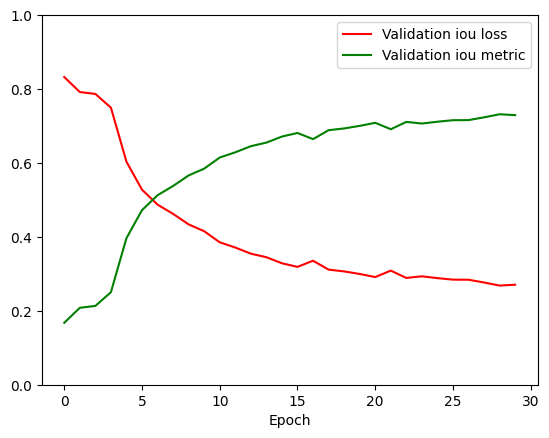

In [21]:
stampa_grafico(model_M)

### TFLite

TFLite (TensorFlow Lite) è una libreria di TensorFlow che consente di convertire ed eseguire modelli di machine learning su dispositivi mobili e piattaforme embedded. Offre ottimizzazioni per ridurre le dimensioni del modello, accelerazioni hardware e funzionalità avanzate. L'obiettivo è quello di eseguire inferenze di modelli di ML in tempo reale su dispositivi con risorse computazionali limitate.

### Conversione Modello Mobile

In [22]:
# Salvo il modello in formato binario
model_M.save("model_sem.h5")

# Carico il modello con le funzioni di loss personalizzate 
new_model= tf.keras.models.load_model(filepath="model_sem.h5", custom_objects={'iou_loss': iou_loss, 'iou_me':iou_me})

# Creo un oggetto TFLiteConverter che viene utilizzato per convertire il modello Keras in un modello TFLite
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model_M)

# Converto il modello
tflite_model = tflite_converter.convert()

# Salvo il modello in un file
open("tf_lite_model.tflite", "wb").write(tflite_model)


1652248

In [23]:
# Load TFLite model and see some details about input/output
model_path = 'tf_lite_model.tflite'

#  Creo un oggetto Interpreter
tflite_interpreter = tf.lite.Interpreter(model_path=model_path)

# Ottengo e stampo i dettagli di input e di output 
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Alloco la memoria per l'interprete TFLite
tflite_interpreter.allocate_tensors()

== Input details ==
name: serving_default_input_image:0
shape: [  1 128 128   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [  1 128 128   5]
type: <class 'numpy.float32'>


1/1 [==============================] - 0s 20ms/step


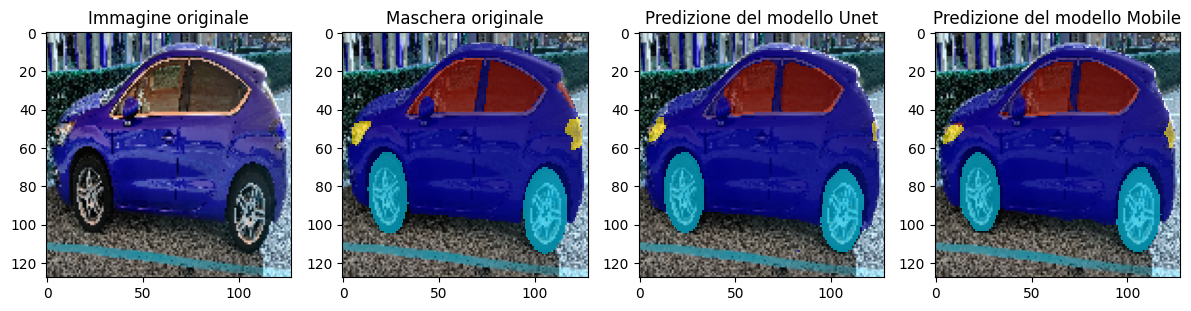

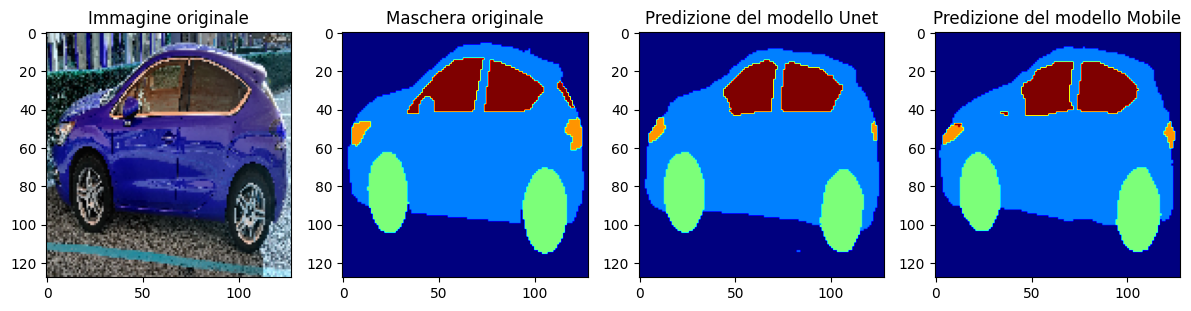

In [30]:
stampa_previsone(model_UN)